# Tesla Stock Price Forecast

In [2]:
import pandas as pd
import quandl
import math, datetime
import numpy as np
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use("ggplot")

### This will NOT make you rich! The value of a company is not based on the features used below.

## Collecting Data

In [2]:
df = quandl.get("WIKI/TSLA")

df = df[["Adj. Open", "Adj. High", "Adj. Low", "Adj. Close", "Adj. Volume"]]
df["HL_PCT"] = (df["Adj. High"] - df["Adj. Close"]) / df["Adj. Close"] * 100.0  # PCT - percent
df["PCT_change"] = (df["Adj. Close"] - df["Adj. Open"]) / df["Adj. Open"] * 100.0
df = df[["Adj. Close", "HL_PCT", "PCT_change", "Adj. Volume"]]

df.fillna(-9999, inplace=True)  # Fills the not a number with -99999, resulting an outlier
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2017-07-10,316.05,0.598007,1.006711,13702080.0
2017-07-11,327.22,0.018336,3.550633,11400054.0
2017-07-12,329.52,1.086429,-0.266344,10297839.0
2017-07-13,323.41,2.532389,-2.029626,8540442.0
2017-07-14,327.78,0.195253,1.420217,5590393.0


## Features and Labels

In [3]:
forecast_col = "Adj. Close"
forecast_out = int(math.ceil(0.1 * len(df)))  # 10% of the frame.
print("Forecast for %d days" %forecast_out)

df["label"] = df[forecast_col].shift(-forecast_out)

df.tail()

Forecast for 178 days


,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2017-07-10,316.05,0.598007,1.006711,13702080.0,NaN
2017-07-11,327.22,0.018336,3.550633,11400054.0,NaN
2017-07-12,329.52,1.086429,-0.266344,10297839.0,NaN
2017-07-13,323.41,2.532389,-2.029626,8540442.0,NaN
2017-07-14,327.78,0.195253,1.420217,5590393.0,NaN


In [4]:
X = np.array(df.drop(["label"], 1))
X = preprocessing.scale(X)  # Adds processing time
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df["label"])

## Training and Testing

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)
clf = LinearRegression(n_jobs=-1)  # Classifier
clf.fit(X_train, y_train)

# Saving the Classifier
# with open("linearregression.pickle", "wb") as f:
#     pickle.dump(clf, f)

# pickle_in = open("linearregression.pickle", "rb")
# clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test)
print("Accuracy: %s" %accuracy)  # square error

Accuracy: 0.765029921769


## Forecasting and Predicting

In [6]:
forecast_set = clf.predict(X_lately)
print("Forecast for the next %s days:\n" %forecast_out, forecast_set, "\nAccuracy:", accuracy)

Forecast for the next 178 days:
 [ 215.6128732   219.21574919  218.11846178  203.95986179  197.41828594
  209.81806568  216.88659993  206.86320153  223.92150979  214.59587355
  206.73890354  209.85370707  200.27948265  204.96696212  207.2385882
  200.13665884  199.51856284  214.44993326  210.33200897  207.57570009
  212.29822885  204.40928032  209.36340484  203.74766592  201.10218723
  198.80773437  208.61526884  212.05999578  215.00902312  205.02466436
  206.04748984  216.44780281  210.09491915  210.52388095  218.09758368
  219.21347857  224.52904096  223.35673092  222.7533497   229.37786751
  233.0093669   230.25951434  229.4162715   231.59371944  233.43136777
  255.8423577   253.20316667  248.37150252  244.61746739  244.77234668
  245.88570055  243.92114468  252.16556571  245.22604502  248.17946722
  268.81272972  259.54502066  264.52136799  265.7779993   267.11110722
  256.71049773  261.14886278  254.26708706  251.73201729  258.82754104
  251.92912424  256.27239699  258.72378897  2

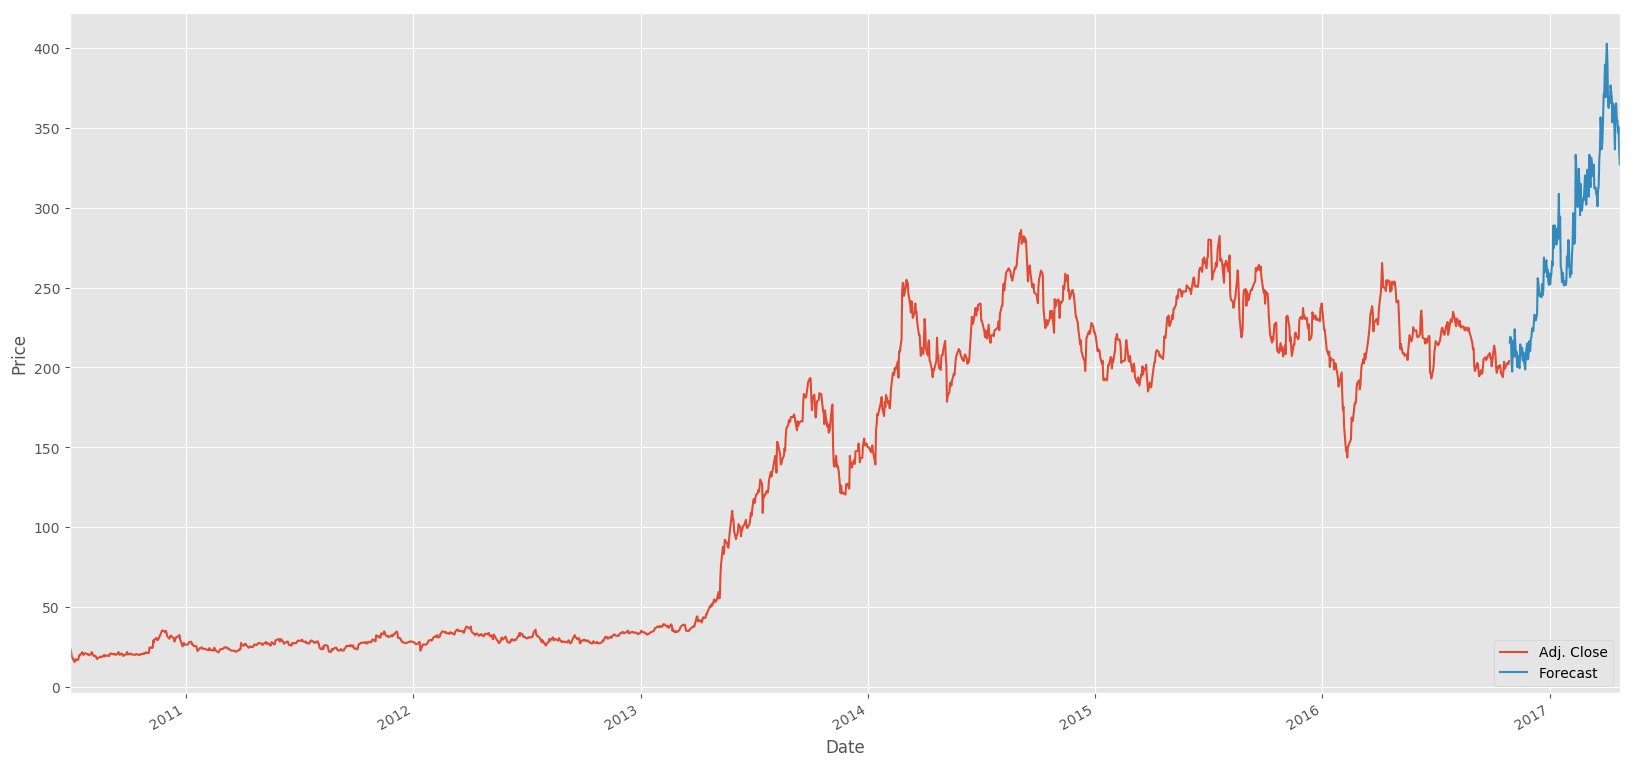

In [7]:
df["Forecast"] = np.nan  # Specify that the column is not a number
last_date = df.iloc[-1].name 
last_unix = last_date.timestamp()
one_day = 86400  # Seconds in a day
next_unix = last_unix + one_day
for i in forecast_set:
    # Making the future features NaN
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]  # The index of the dataframe
    
plt.figure(figsize=(20, 10), dpi= 100)
df["Adj. Close"].plot()
df["Forecast"].plot()
plt.legend(loc=4)  # Putting it on the bottom right
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()